In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gpdp
mean=False
dust_prior = gpdp.DustPrior('./', mean=mean)
import lbg_forecast.sfh as sfh

Loading Models
Loading Complete


In [ ]:
#recent_sfrs = np.log10(sfh.calculate_recent_sfr(redshift, 10**mass, logsfrs))
##recent_sfrs.shape

(2000000,)

In [13]:
#np.save("dust_data/popcosmos_recent_sfrs.npy", recent_sfrs)

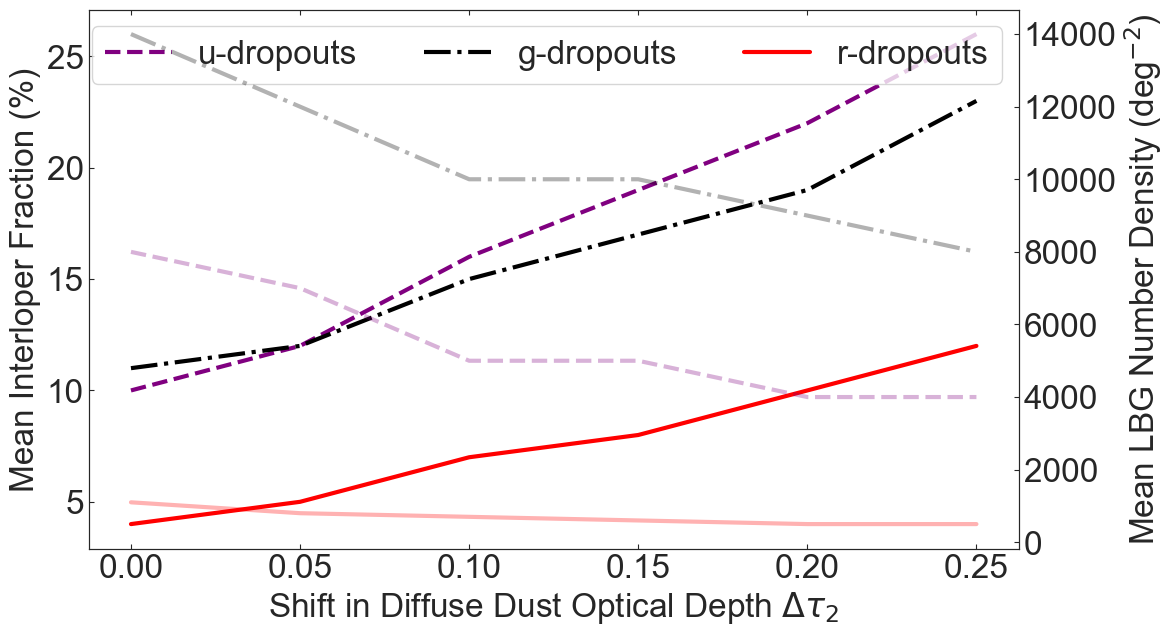

In [2]:
dtau = np.array([0.0, 0.05, 0.1, 0.15, 0.20, 0.25])
uint = np.array([10, 12, 16, 19, 22, 26])
gint = np.array([11, 12, 15, 17, 19, 23])
rint = np.array([4, 5, 7, 8, 10, 12])
u_nden = np.array([8000, 7000, 5000, 5000, 4000, 4000])
g_nden = np.array([14000, 12000, 10000, 10000, 9000, 8000])
r_nden = np.array([1100, 800, 700, 600, 500, 500])

fig, ax1 = plt.subplots(figsize=(12, 7))
ax2 = ax1.twinx()

lw=3

ax1.plot(dtau, uint, label='u-dropouts', ls='--', color='purple', lw=lw)
ax1.plot(dtau, gint, label='g-dropouts', ls='-.', color='black', lw=lw)
ax1.plot(dtau, rint, label='r-dropouts', ls='-', color='red', lw=lw)

ax2.plot(dtau, u_nden, label='u-dropouts', ls='--', color='purple', lw=lw, alpha=0.3)
ax2.plot(dtau, g_nden, label='g-dropouts', ls='-.', color='black', lw=lw, alpha=0.3)
ax2.plot(dtau, r_nden, label='r-dropouts', ls='-', color='red', lw=lw, alpha=0.3)

fs=24

ax1.set_xlabel("Shift in Diffuse Dust Optical Depth $\Delta\\tau_{2}$", fontsize=fs)
ax1.set_ylabel("Mean Interloper Fraction (%)", fontsize=fs)

ax2.set_ylabel("Mean LBG Number Density (deg$^{-2}$)", fontsize=fs)

ax1.tick_params('x', labelsize="24")
ax1.tick_params('y', labelsize="24")
ax2.tick_params('y', labelsize="24")

ax1.legend(ncols=3, fontsize=fs)

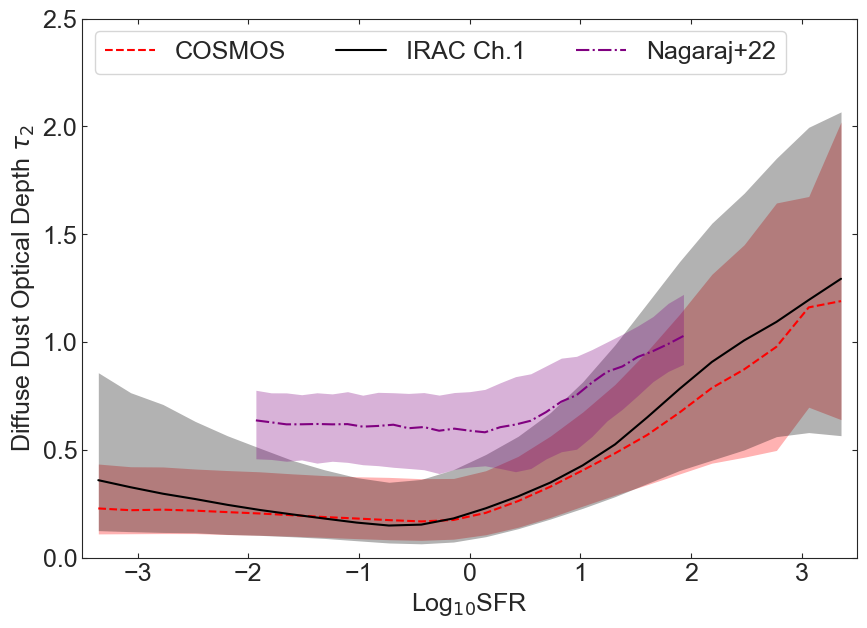

In [28]:
import scipy as sc

def conf_lim(c, std, n):
    return (c*std)/np.sqrt(n)

def quantile975(x):
    return np.quantile(x, 0.975)

def quantile025(x):
    return np.quantile(x, 0.025)

def quantile84(x):
    return np.quantile(x, 0.84)

def quantile16(x):
    return np.quantile(x, 0.16)

def process_samples_median(x, y, xl, xh, ngrid=15):

    bin_median, bin_edges, binnumber = sc.stats.binned_statistic(x, y, 'median', np.linspace(xl, xh, ngrid))
    bin_975, bin_edges, binnumber = sc.stats.binned_statistic(x, y, quantile975, np.linspace(xl, xh, ngrid))
    bin_025, bin_edges, binnumber = sc.stats.binned_statistic(x, y, quantile025, np.linspace(xl, xh, ngrid))
    bin_84, bin_edges, binnumber = sc.stats.binned_statistic(x, y, quantile84, np.linspace(xl, xh, ngrid))
    bin_16, bin_edges, binnumber = sc.stats.binned_statistic(x, y, quantile16, np.linspace(xl, xh, ngrid))

    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    return bin_centers, bin_median, bin_025, bin_975, bin_16, bin_84


pops = dust_prior.preloaded_popcosmos_samples
sfrs_pop = dust_prior.preloaded_recent_sfrs
dust_params = pops[:, 8:11]
logmass_pop = pops[:, 0]
redshift_pop = pops[:, -1]

pop_sfr_samples = sfrs_pop
pop_tau2_samples = dust_params[:, 0]

zl=0.0
zu=0.4
mlim=8.5

zmlimits = np.array([[0.0, 0.4, 8.5],
                    [0.4, 0.8, 9.0],
                    [0.8, 1.2, 9.5],
                    [1.2, 1.6, 9.7],
                    [1.6, 2.0, 9.8],
                    [2.0, 2.4, 9.9],
                    [2.4, 2.8, 10.0],
                    [2.8, 3.2, 10.0],
                    [3.2, 3.6, 10.0]])

indexes = []
for bin in zmlimits:
    z_inds = np.where((logmass_pop > bin[2])&(redshift_pop > bin[0])&(redshift_pop < bin[1]))[0]
    indexes.append(z_inds)

indexes = np.hstack(indexes)

pop_sfr_samples_cut = pop_sfr_samples[indexes]
pop_tau2_samples_cut = pop_tau2_samples[indexes]

irac_sfr_samples = np.squeeze(dust_prior.irac_logsfr)
irac_tau2_samples = np.squeeze(dust_prior.irac_tau2)

x1, y1, y025, y97, y16, y84 = process_samples_median(pop_sfr_samples, pop_tau2_samples, -3.5, 3.5, 25)
x1irac, y1irac, y025irac, y97irac, y16irac, y84irac = process_samples_median(irac_sfr_samples, irac_tau2_samples, -3.5, 3.5, 25)

plt.plot(x1, y1, color='red', ls='--', label='COSMOS')
plt.plot(x1irac, y1irac, color='k', label='IRAC Ch.1')

plt.fill_between(x1, y16, y84, alpha=0.3, color='red', lw=0)
#plt.fill_between(x1, y025, y97, alpha=0.2, color='red')

plt.fill_between(x1irac, y16irac, y84irac, alpha=0.3, color='k', lw=0)
#plt.fill_between(x1irac, y025irac, y97irac, alpha=0.2, color='blue')

params = dust_prior.get_nagaraj22_samples()
n, tau, tau1, _, _, _, sfrs_nag = params

x1nag, y1nag, y025nag, y97nag, y16nag, y84nag = process_samples_median(sfrs_nag, tau, -2.0, 2.0, 30)

plt.plot(x1nag, y1nag, color='purple', ls='-.', label='Nagaraj+22')
plt.fill_between(x1nag, y16nag, y84nag, alpha=0.3, color='purple', lw=0)

plt.xlim(-3.5, 3.5)
plt.ylim(0.0, 2.5)


fs=18

plt.legend(loc='upper left', ncols=3, fontsize=fs)

plt.xlabel('Log$_{10}$SFR', fontsize=fs)
plt.ylabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)

axes = plt.gca()

axes.tick_params('x', labelsize=18)
axes.tick_params('y', labelsize=18)

fig = plt.gcf()
fig.set_size_inches(10, 7)


(2000000, 16) (2000000,)


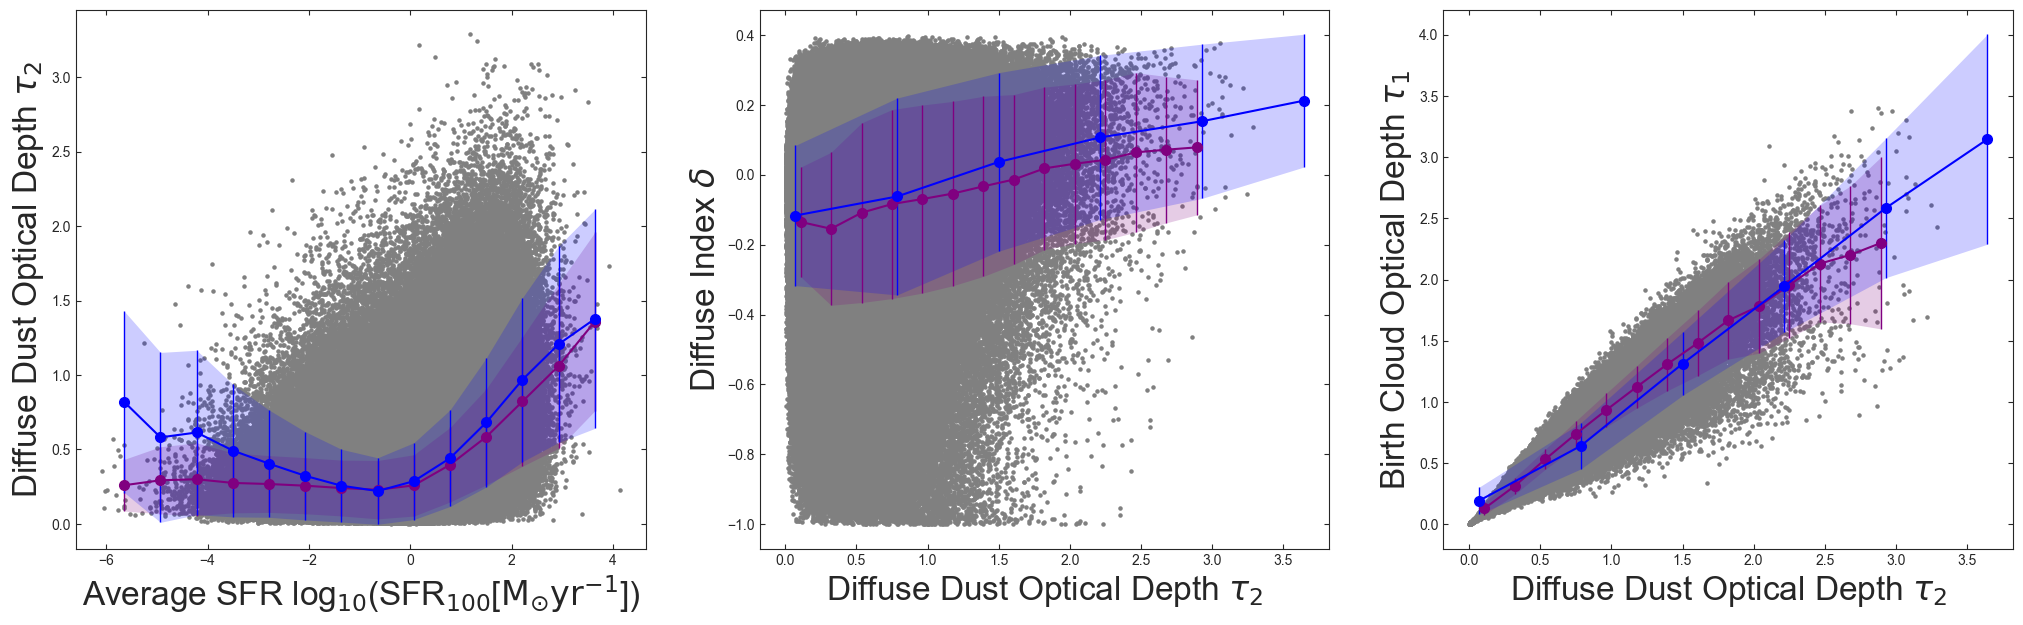

In [4]:
pops = dust_prior.preloaded_popcosmos_samples
sfrs_pop = dust_prior.preloaded_recent_sfrs
dust_params = pops[:, 8:11]

f, ax = plt.subplots(1, 3, figsize=(25, 7))

s=5
a=1.0
fs=24
colour='grey'

#dust2
ax[0].scatter(sfrs_pop, dust_params[:, 0], s=s, color=colour, alpha=a)
ax[0].set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[$\mathrm{M}_{\odot} \mathrm{yr}^{-1}$])', fontsize=fs)
ax[0].set_ylabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)

x1, y1, y1err = gpdp.process_samples(sfrs_pop, dust_params[:, 0], -6, 4, 15)
ax[0].errorbar(x1, y1, y1err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1)
ax[0].fill_between(x1, y1-y1err, y1+y1err, alpha=0.2, color='purple', lw=0)

x1irac, y1irac, y1errirac = gpdp.process_samples(np.squeeze(dust_prior.irac_logsfr), np.squeeze(dust_prior.irac_tau2), -6, 4, 15)
ax[0].errorbar(x1irac, y1irac, y1errirac, fmt='o', color='blue', ls='-', ms=7, elinewidth=1)
ax[0].fill_between(x1irac, y1irac-y1errirac, y1irac+y1errirac, alpha=0.2, color='blue', lw=0)

#dust index
ax[1].scatter(dust_params[:, 0], dust_params[:, 1], s=s, color=colour, alpha=a)
ax[1].set_xlabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)
ax[1].set_ylabel('Diffuse Index $\delta$', fontsize=fs)

x2, y2, y2err = gpdp.process_samples(dust_params[:, 0], dust_params[:, 1], 0, 3, 15)
ax[1].errorbar(x2, y2, y2err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1)
ax[1].fill_between(x2, y2-y2err, y2+y2err, alpha=0.2, color='purple', lw=0)

x2irac, y2irac, y2errirac = gpdp.process_samples(np.squeeze(dust_prior.irac_tau2), np.squeeze(dust_prior.irac_index), -6, 4, 15)
ax[1].errorbar(x2irac, y2irac, y2errirac, fmt='o', color='blue', ls='-', ms=7, elinewidth=1)
ax[1].fill_between(x2irac, y2irac-y2errirac, y2irac+y2errirac, alpha=0.2, color='blue', lw=0)

#dust 1
ax[2].scatter(dust_params[:, 0], dust_params[:, 2]*dust_params[:, 0], s=s, color=colour, alpha=a)
ax[2].set_xlabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)
ax[2].set_ylabel('Birth Cloud Optical Depth $\\tau_{1}$', fontsize=fs)

x3, y3, y3err = gpdp.process_samples(dust_params[:, 0], dust_params[:, 2]*dust_params[:, 0], 0, 3, 15)
ax[2].errorbar(x3, y3, y3err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1)
ax[2].fill_between(x3, y3-y3err, y3+y3err, alpha=0.2, color='purple', lw=0)

x3irac, y3irac, y3errirac = gpdp.process_samples(np.squeeze(dust_prior.irac_tau2), np.squeeze(dust_prior.irac_tau1), -6, 4, 15)
ax[2].errorbar(x3irac, y3irac, y3errirac, fmt='o', color='blue', ls='-', ms=7, elinewidth=1)
ax[2].fill_between(x3irac, y3irac-y3errirac, y3irac+y3errirac, alpha=0.2, color='blue', lw=0)

print(pops.shape, sfrs_pop.shape)

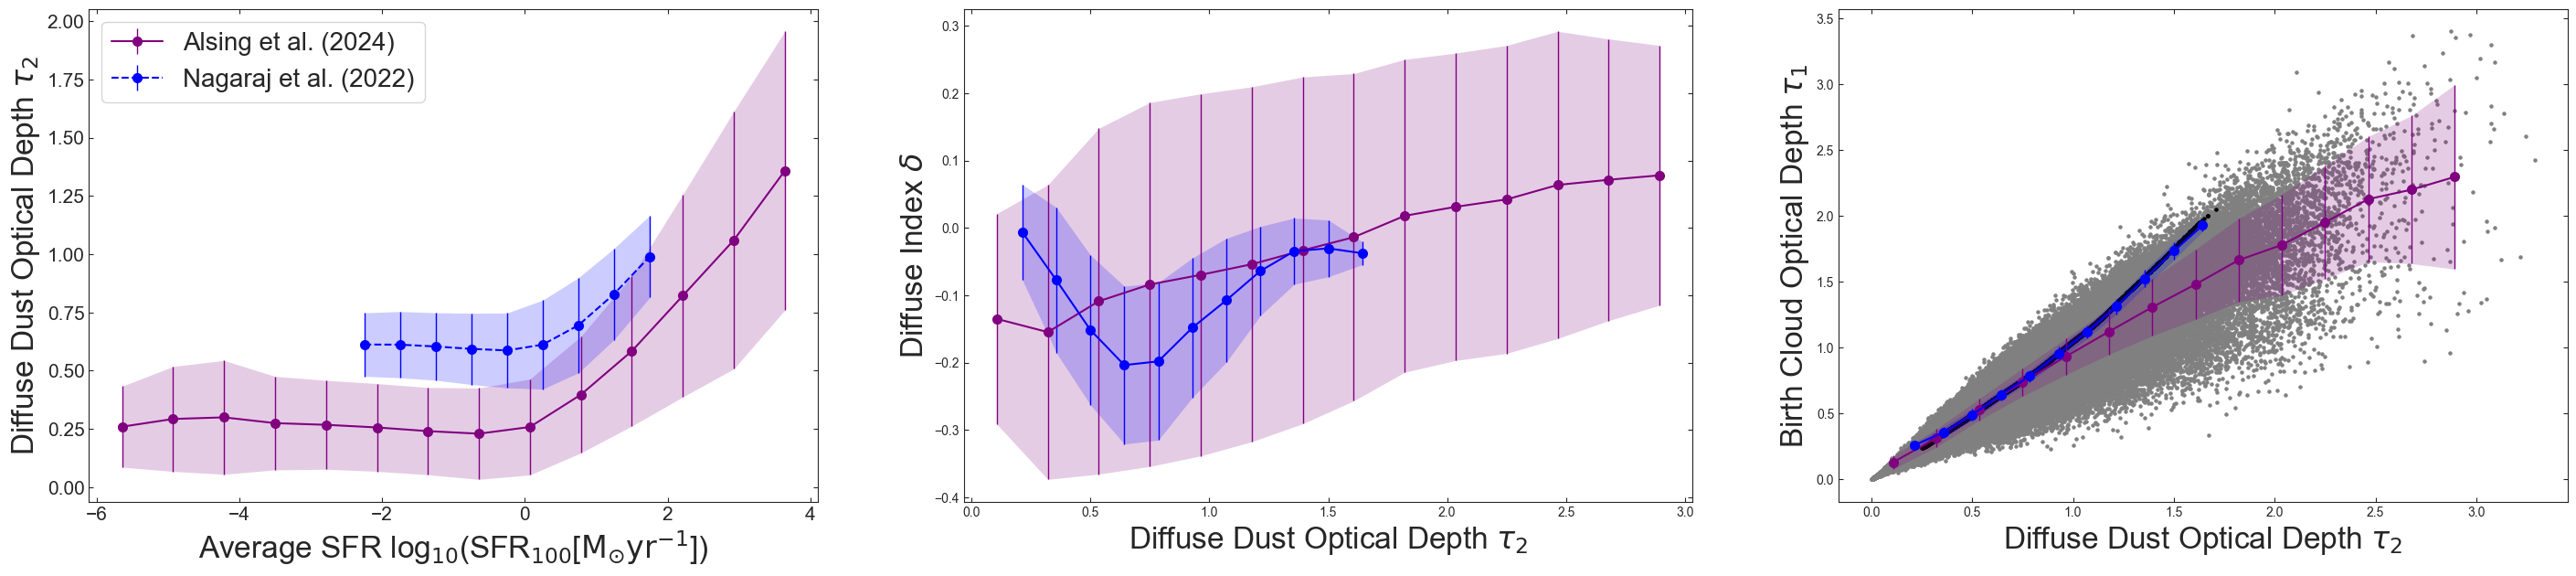

In [5]:
params = dust_prior.get_nagaraj22_samples()
n, tau, tau1, _, _, _, sfrs_nag = params

pops = dust_prior.preloaded_popcosmos_samples
sfrs_pop = dust_prior.preloaded_recent_sfrs
dust_params = pops[:, 8:11]

f, ax = plt.subplots(1, 3, figsize=(35, 7))

s=5
a=1.0
fs=24
colour='grey'
colour_nag = 'black'

#dust2
#ax[0].scatter(sfrs_pop, dust_params[:, 0], s=s, color=colour, alpha=a)
#ax[0].scatter(sfrs_nag, tau, s=s, color=colour_nag, alpha=a)
ax[0].set_xlabel('Average SFR log$_{10}$(SFR$_{100}$[$\mathrm{M}_{\odot} \mathrm{yr}^{-1}$])', fontsize=fs)
ax[0].set_ylabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)
ax[0].tick_params('x', labelsize=15)
ax[0].tick_params('y', labelsize=15)

x1, y1, y1err = gpdp.process_samples(sfrs_pop, dust_params[:, 0], -6, 4, 15)
ax[0].errorbar(x1, y1, y1err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1, label='Alsing et al. (2024)')
ax[0].fill_between(x1, y1-y1err, y1+y1err, alpha=0.2, color='purple', lw=0)

x1nag, y1nag, y1errnag = gpdp.process_samples(sfrs_nag, tau, -5, 2, 15)
ax[0].errorbar(x1nag, y1nag, y1errnag, fmt='o', color='blue', ls='--', ms=7, elinewidth=1, label='Nagaraj et al. (2022)')
ax[0].fill_between(x1nag, y1nag-y1errnag, y1nag+y1errnag, alpha=0.2, color='blue', lw=0)

ax[0].legend(loc='upper left', fontsize=20)

#dust index
#ax[1].scatter(dust_params[:, 0], dust_params[:, 1], s=s, color=colour, alpha=a)
#ax[1].scatter(tau, n, s=s, color=colour_nag, alpha=a)
ax[1].set_xlabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)
ax[1].set_ylabel('Diffuse Index $\delta$', fontsize=fs)

x2, y2, y2err = gpdp.process_samples(dust_params[:, 0], dust_params[:, 1], 0, 3, 15)
ax[1].errorbar(x2, y2, y2err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1)
ax[1].fill_between(x2, y2-y2err, y2+y2err, alpha=0.2, color='purple', lw=0)

x2nag, y2nag, y2errnag = gpdp.process_samples(tau, n, 0, 2, 15)
ax[1].errorbar(x2nag, y2nag, y2errnag, fmt='o', color='blue', ls='-', ms=7, elinewidth=1)
ax[1].fill_between(x2nag, y2nag-y2errnag, y2nag+y2errnag, alpha=0.2, color='blue', lw=0)

#dust 1
ax[2].scatter(dust_params[:, 0], dust_params[:, 2]*dust_params[:, 0], s=s, color=colour, alpha=a)
ax[2].scatter(tau, tau1, s=s, color=colour_nag, alpha=a)
ax[2].set_xlabel('Diffuse Dust Optical Depth $\\tau_{2}$', fontsize=fs)
ax[2].set_ylabel('Birth Cloud Optical Depth $\\tau_{1}$', fontsize=fs)

x3, y3, y3err = gpdp.process_samples(dust_params[:, 0], dust_params[:, 2]*dust_params[:, 0], 0, 3, 15)
ax[2].errorbar(x3, y3, y3err, fmt='o', color='purple', ls='-', ms=7, elinewidth=1)
ax[2].fill_between(x3, y3-y3err, y3+y3err, alpha=0.2, color='purple', lw=0)

x3nag, y3nag, y3errnag = gpdp.process_samples(tau, tau1, 0, 2, 15)
ax[2].errorbar(x3nag, y3nag, y3errnag, fmt='o', color='blue', ls='-', ms=7, elinewidth=1)
ax[2].fill_between(x3nag, y3nag-y3errnag, y3nag+y3errnag, alpha=0.2, color='blue', lw=0)

(8000, 17)


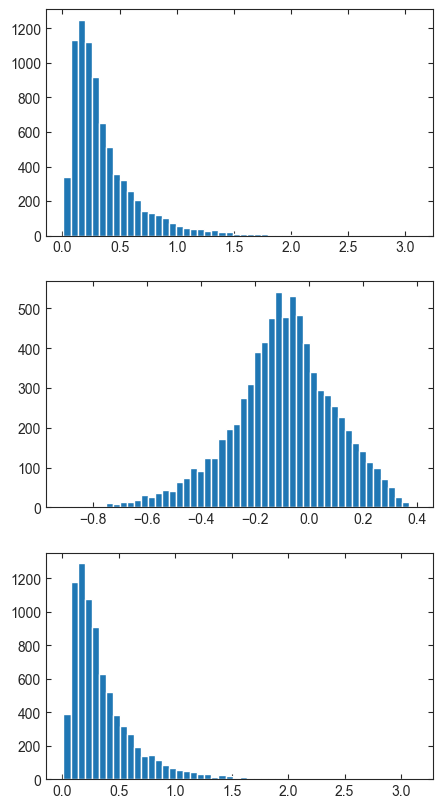

In [9]:
nsamples=10000
sps_params = np.load("sps_parameter_samples/sps_test_0.npy")[:nsamples, :]
sps_params = np.vstack(sps_params)[:nsamples, :]
print(sps_params.shape)

redshift = sps_params[:, 0]
dust1 = sps_params[:, 2]
dust2 = sps_params[:, 3]
dust_index = sps_params[:, 4]
mass = sps_params[:, -1]
logsfrratios = sps_params[:, 10:-1]


f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))
t2, d, t1 = dust_prior.sample_dust_model_irac(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

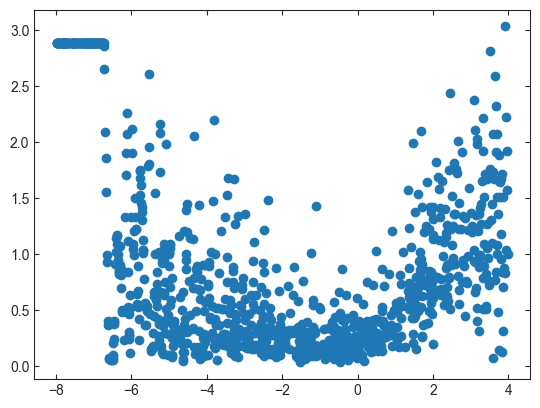

In [16]:
nsamples=1000
#sps_params = np.load("sps_parameter_samples/sps_test.npy")[:nsamples, :]
#sps_params = np.vstack(sps_params)[:nsamples, :]
#print(sps_params.shape)

#redshift = sps_params[:, 0]
#dust1 = sps_params[:, 2]
#dust2 = sps_params[:, 3]
#dust_index = sps_params[:, 4]
#mass = sps_params[:, -1]
#logsfrratios = sps_params[:, 10:-1]

recent_sfrs = np.random.uniform(-8, 4, nsamples)#np.log10(sfh.calculate_recent_sfr(redshift, mass, logsfrratios))

sampled_dust2 = dust_prior.sample_dust2_irac(recent_sfrs)
plt.scatter(recent_sfrs, sampled_dust2)


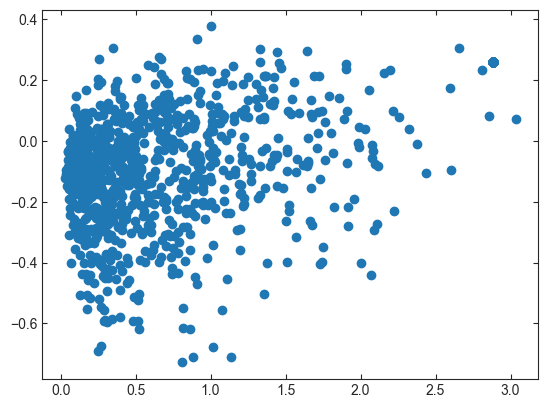

In [17]:
sampled_dust_index = dust_prior.sample_dust_index(sampled_dust2)
plt.scatter(sampled_dust2, sampled_dust_index)

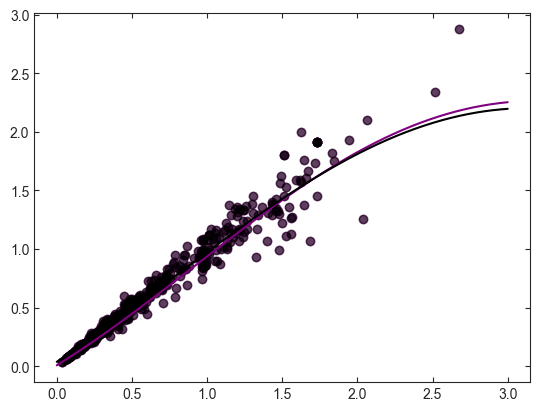

In [28]:
sampled_dust1 = dust_prior.sample_dust1(sampled_dust2, debug=True)

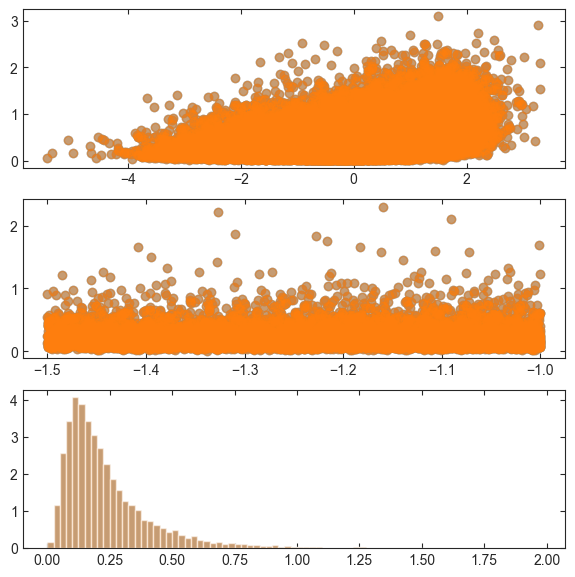

In [29]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

new_sfrs = recent_sfrs#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(recent_sfrs, dust2, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -1
inds0 = np.where((recent_sfrs<sfr_point)&(recent_sfrs>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(recent_sfrs[inds0], dust2[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(dust2[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


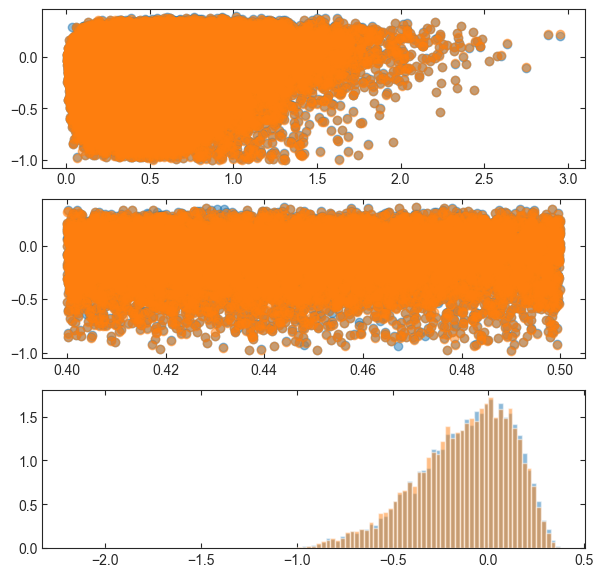

In [7]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust_index, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust_index[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(dust_index[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


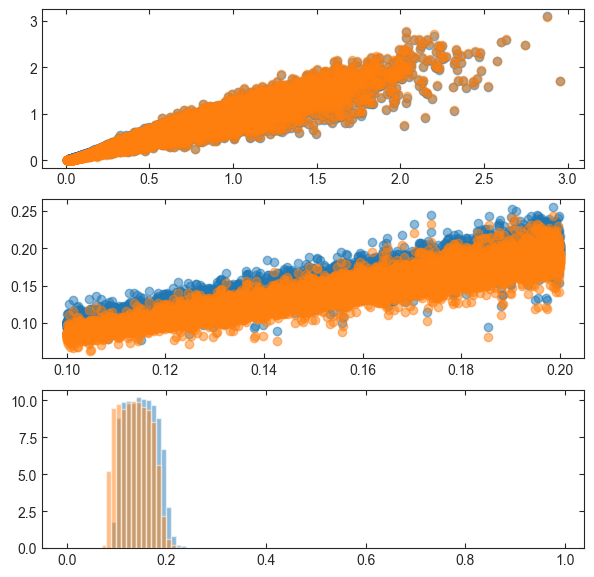

In [8]:
recent_sfrs, dust2, dust_index, dust1 = dust_prior.get_pop_cosmos_samples(100000)

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = dust2#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(dust2, dust1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((dust2<dust2_point)&(dust2>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(dust2[inds0], dust1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(dust1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

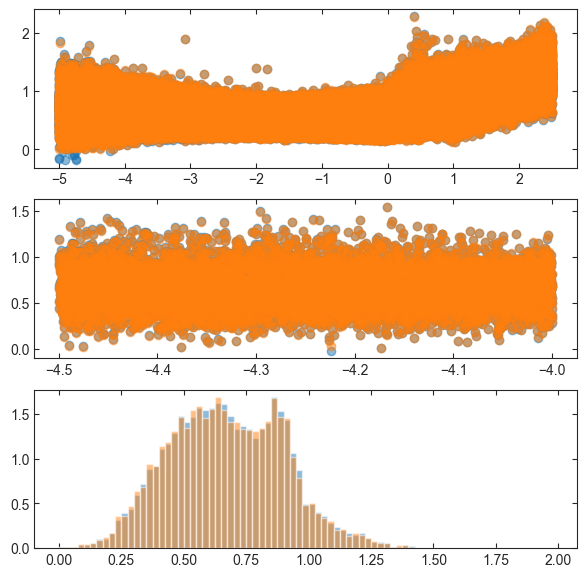

In [9]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

new_sfrs = sfr#np.random.uniform(-4, 3, 100000)
dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model_nag(new_sfrs)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(sfr, tau, alpha=0.5)
ax[0].scatter(new_sfrs, dust2_gp, alpha=0.5)

sfr_point = -4
inds0 = np.where((sfr<sfr_point)&(sfr>sfr_point-0.5))[0]
inds = np.where((new_sfrs<sfr_point)&(new_sfrs>sfr_point-0.5))[0]
ax[1].scatter(sfr[inds0], tau[inds0], alpha=0.5)
ax[1].scatter(new_sfrs[inds], dust2_gp[inds], alpha=0.5)

bins = np.arange(0, 2, 0.025)
histogram = ax[2].hist(tau[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust2_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


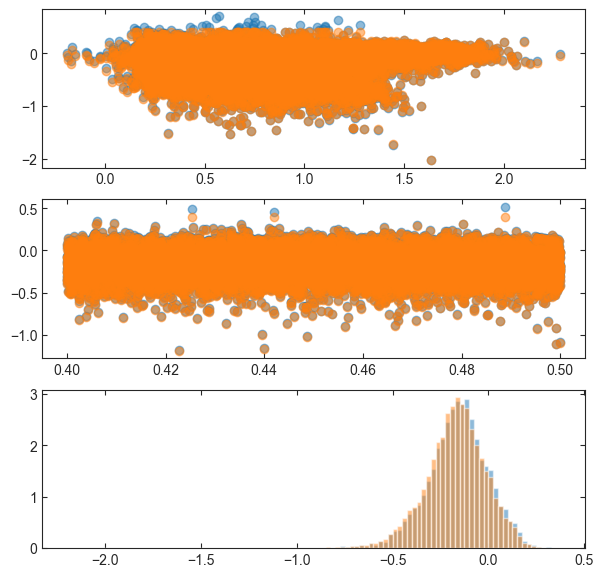

In [10]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust_index_gp = dust_prior.sample_dust_index_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, n, alpha=0.5)
ax[0].scatter(dust2_gp, dust_index_gp, alpha=0.5)

dust2_point = 0.5
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], n[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust_index_gp[inds], alpha=0.5)

bins = np.arange(-2.2, 0.4, 0.025)
histogram = ax[2].hist(n[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust_index_gp[inds], density=True, bins=bins, alpha=0.5)

Loading Models
Loading Complete


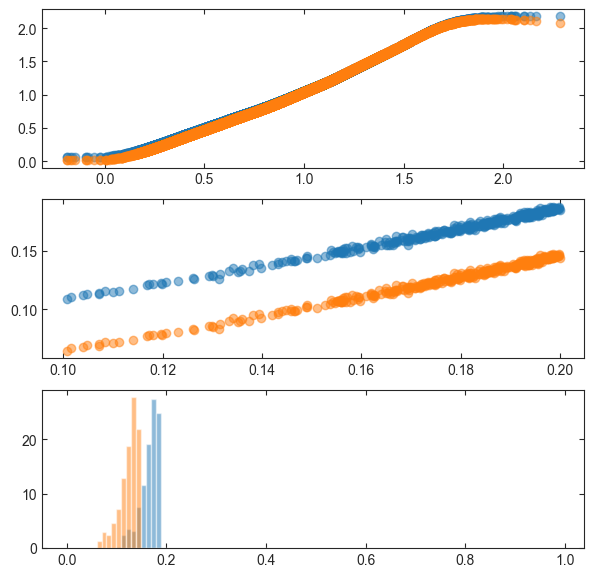

In [11]:
n, tau, tau1, ne, taue, tau1e, sfr = dust_prior.get_nagaraj22_samples()

dust_prior = gpdp.DustPrior('./', mean=mean)
#dust2_gp, dust_index_gp, dust1_gp = dust_prior.sample_dust_model(recent_sfrs)
dust2_gp = tau#np.random.uniform(0, 4, 500000)
dust1_gp = dust_prior.sample_dust1_nag(dust2_gp)

f, ax = plt.subplots(3, 1, figsize=(7, 7))
ax[0].scatter(tau, tau1, alpha=0.5)
ax[0].scatter(dust2_gp, dust1_gp, alpha=0.5)

dust2_point = 0.2
inds0 = np.where((tau<dust2_point)&(tau>dust2_point-0.1))[0]
inds = np.where((dust2_gp<dust2_point)&(dust2_gp>dust2_point-0.1))[0]

ax[1].scatter(tau[inds0], tau1[inds0], alpha=0.5)
ax[1].scatter(dust2_gp[inds], dust1_gp[inds], alpha=0.5)

bins = np.arange(0.0, 1.0, 0.01)
histogram = ax[2].hist(tau1[inds0], density=True, bins=bins, alpha=0.5)
histogram = ax[2].hist(dust1_gp[inds], density=True, bins=bins, alpha=0.5)

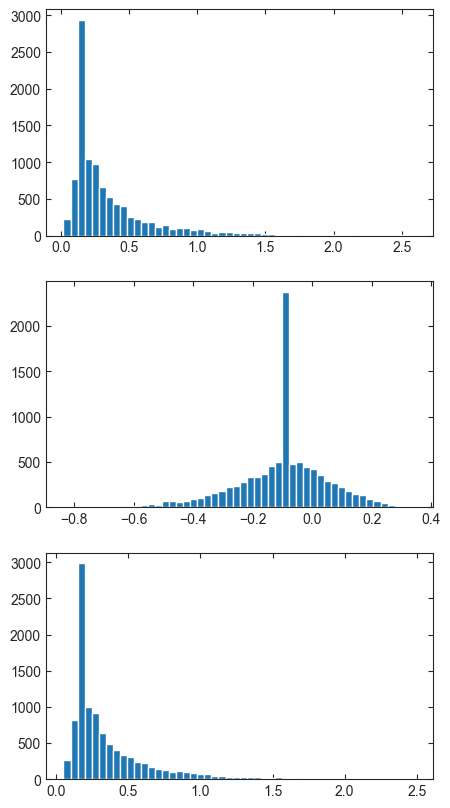

In [19]:
f, ax = plt.subplots(3,1, figsize=(5, 10))
sfr_test = np.random.uniform(-8, 3, 10000)
t2, d, t1 = dust_prior.sample_dust_model(sfr_test)
h1 = ax[0].hist(t2, bins=50)
h2 = ax[1].hist(d, bins=50)
h3 = ax[2].hist(t1, bins=50)

In [13]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)

In [14]:
#run = 'pop'
#spsp = np.load("sps_parameter_samples/sps_"+run+".npy")[0, :10000, :]
#spsp.shape

In [15]:
#spsp = spsp[np.where((spsp[:, 0] < 3.0) & (spsp[:, 0] > 0.5))[0]]
#spsp.shape

In [7]:
## DONT DELETE

from duste.DustAttnCalc import DustAttnCalc
ngal = 10000

logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-2.06,2.11,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
z= np.random.uniform(0.51,2.83,ngal)
i=np.random.uniform(0.09,0.97,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_small.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_logM_logSFR_logZ_z_axis_ratio_n_dust2_msfrlogZzin_d2_map_jp_new_-1_3125_dlw_0.0_eff_0_3125_HB.dat
Measured grid length from file: 5
Mins: {'logM': 8.74, 'sfr': -2.06, 'logZ': -1.7, 'z': 0.51, 'i': 0.09, 'd1': 0.01, 'd2': 0.01, 'de': 0.01}
Maxs: {'logM': 11.3, 'sfr': 2.11, 'logZ': 0.18, 'z': 2.83, 'i': 0.97, 'd1': 2.23, 'd2': 1.95, 'de': 2.19}
Marginalizing over i
Trace file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/trace_int_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20.nc
Dat file: /Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/duste/TraceFiles/Interp_dust1_dust2_d1_d2_mapv2_-1_20_dlw_-1.0_eff_0_20_HB.dat
Measured grid length f

<ErrorbarContainer object of 3 artists>

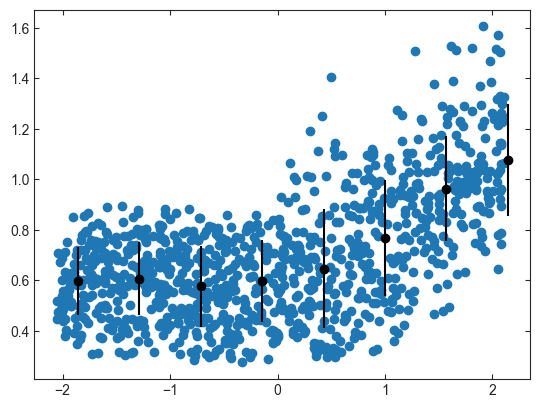

In [6]:
plt.scatter(sfr, tau)
x, y, yerr = gpdp.process_samples(sfr, tau, -5, 3, 15)
plt.errorbar(x, y, yerr, fmt='ko')

In [18]:
#nagaraj_data = np.vstack((n, tau, tau1, ne, taue, tau1e, sfr))
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj_data)